### Multiclass task: non-event vs. SI vs. SSC 
Notebook structure:
1. Balance classes: undersample non-events, retaining only as many samples as the majority class between SI and SSC (namely SSC); oversample the minority class by applying SMOTE on the training set.
2. Pre-process the data via wavelet scattering network.
3. Train multi-class classifiers, perform 10 folds cross-validation, and evaluate performances.
5. Repeat the process with a reduced set of features (criteria adopted: random forest Gini's importance).

In [1]:
import pandas as pd
import os
import random 
import numpy as np
from collections import Counter
import torch
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from classification_utils import fill_NaN, compute_Scattering1D, get_logistic_model, train_logistic_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE, SVMSMOTE
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold, StratifiedKFold, GridSearchCV
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

random.seed(2)
np.random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed_all(2)

#### Paths

In [2]:
ssc_path = 'labelled_data/SSC/'
si_path = 'labelled_data/SI/'
non_event_path = 'labelled_data/before_event/'
multiclass_sample = 'labelled_data/sample_for_multiclass_w_SMOTE.txt'

In [3]:
# scattering params
T = 20*60 + 1 
J = 10
Q = 5 
log_eps = 1e-6

### Classification using Wavelets Scattering Network features & SMOTE to balance classes

#### Get data

use always same sample for reproducibility

In [4]:
if os.path.exists(multiclass_sample):
    # if I already extracted a sample, read it
    all_seq_data_files = []
    with open(multiclass_sample, 'r') as file:
        for line in file:
            all_seq_data_files.append(line.strip())
    print( Counter([all_seq_data_files[i].split('/')[1] for i in range(len(all_seq_data_files))]) )

    si_files, ssc_files, random_non_ev_files = [], [], []
    for path in all_seq_data_files:
        if path.split('/')[1] == 'SI':
            si_files.append(path)
        elif path.split('/')[1] == 'SSC':
            ssc_files.append(path)
        elif path.split('/')[1] == 'before_event':
            random_non_ev_files.append(path)
        else:
            raise ValueError('File not belonging to any class!')
else:

    # get all data files paths
    # use all SI and all SSC, and a sample of non-events 
    si_files = [si_path + item for item in os.listdir(si_path)] 
    ssc_files = [ssc_path + item for item in os.listdir(ssc_path)] 
    non_ev_files = [non_event_path + item for item in os.listdir(non_event_path)]

    print('SI: {}, SSC: {}'.format(len(si_files), len(ssc_files)))

    # number of non-event to random sample (take as many non-events as the majority class between SSC & SI)
    sample_non_ev = np.max([len(si_files), len(ssc_files)])
    print('Non-events: {}'.format(sample_non_ev))

    # SAMPLE NON-EVENT
    random_non_ev_files = random.sample(non_ev_files, sample_non_ev)
    all_seq_data_files = si_files + ssc_files + random_non_ev_files

    # save sampled used to use always the same in the following trials
    with open(multiclass_sample, 'w') as file:
        for string in all_seq_data_files:
            file.write(string + '\n')

Counter({'SSC': 120, 'before_event': 120, 'SI': 73})


In [5]:
# initialize 2D tensors (each row is a different sequence)

seq_si = torch.zeros(len(si_files), T, dtype=torch.float32)
seq_ssc = torch.zeros(len(ssc_files), T, dtype=torch.float32)
seq_ne = torch.zeros(len(random_non_ev_files), T, dtype=torch.float32)

lab_dict = {'SSC':seq_ssc, 'SI':seq_si, 'before_event':seq_ne} # which tensor to update based on class

filling_method = 'linear_interpolation' 

indx_to_update = {'SSC':0, 'SI':0, 'before_event':0} # index of seq to update in each tensor 
for e in all_seq_data_files:
    # get sequence
    df = pd.read_csv(e)
    seq = df.sort_values(by=['Date_UTC' if 'Date_UTC' in df.columns else 'Unnamed: 0']).dbn_nez

    # get right tensor to fill
    sequences_class_x = lab_dict[e.split('/')[1]]
    
    # deal with NaN
    seq_filled = fill_NaN(seq, filling_method)

    # convert from np array to pytorch tensor
    seq_filled = torch.from_numpy(seq_filled)

    # compute columns from which to start filling
    starting_col_index = (T - seq_filled.numel()) // 2

    # add data to sequences tensor
    i = indx_to_update[e.split('/')[1]]
    sequences_class_x[i,starting_col_index:starting_col_index + seq_filled.numel()] = seq_filled

    # update counter (next row)
    indx_to_update[e.split('/')[1]] += 1

In [6]:
len(seq_ne), len(seq_si), len(seq_ssc)

(120, 73, 120)

In [7]:
# concat tensors and labels
all_seqs = torch.cat([seq_si, seq_ssc, seq_ne], dim=0).numpy()  
ys = len(seq_si)*['SI'] + len(seq_ssc)*['SSC'] + len(seq_ne)*['non-event']

# to tensor
seqs = torch.from_numpy(all_seqs)

# labels to tensor + map classes to int
# replace str with int code
lab_to_int = {'non-event': 0, 'SI': 1, 'SSC': 2}
y = list(map(lambda x: lab_to_int[x], ys))
# to tensor
y = torch.tensor(y)

#### Split Train/Test sets

In [8]:
# split train and test set 
X_train, X_test, y_train, y_test = train_test_split(seqs, y, test_size=0.3, shuffle=True, random_state=2) 

In [9]:
np.shape(seqs), np.shape(X_train), np.shape(X_test)

(torch.Size([313, 1201]), torch.Size([219, 1201]), torch.Size([94, 1201]))

#### Create synthetic sequences using SMOTE
Picked as many non-event as the majority class between SSC and SI (aka SSC);
now use SMOTE (oversampling) to balance the classes.

**NOTE**: apply SMOTE only on train set (test set should contain only real sequences).

In [10]:
# SMOTE
smote = SMOTE(k_neighbors=20, random_state=2)
X_train_resampled_np, y_train_resampled_np = smote.fit_resample(X_train, y_train)

# to tensor
X_train_resampled, y_train_resampled = torch.tensor(X_train_resampled_np), torch.tensor(y_train_resampled_np)

In [11]:
# shuffle so that synthetic sequences are not all the end
X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=2)

In [12]:
Counter(y_train_resampled_np)

Counter({0: 90, 2: 90, 1: 90})

#### Wavelet Scattering Transform to extract features

In [13]:
Sc_all_train = compute_Scattering1D(X_train_resampled, T, J, Q, log_eps)
Sc_all_test = compute_Scattering1D(X_test, T, J, Q, log_eps)

In [14]:
np.shape(Sc_all_train)

torch.Size([270, 235])

In [15]:
np.shape(Sc_all_test)

torch.Size([94, 235])

In [16]:
np.isnan(Sc_all_train).any(), np.isnan(Sc_all_test).any()

(tensor(0, dtype=torch.uint8), tensor(0, dtype=torch.uint8))

#### Standardize data using training mean and variance

In [17]:
mu_train = Sc_all_train.mean(dim=0)
std_train = Sc_all_train.std(dim=0)

Sx_train = (Sc_all_train - mu_train) / std_train
Sx_test = (Sc_all_test - mu_train) / std_train

_________

#### Visualization

In [18]:
feats_df = pd.DataFrame({'feature_1':Sx_train[:,0], 'feature_2':Sx_train[:,1], 'feature_3':Sx_train[:,2], 
                         'feature_3rdlast':Sx_train[:,-3], 'feature_2ndlast':Sx_train[:,-2], 'feature_last':Sx_train[:,-1], 
                         'label':y_train_resampled})

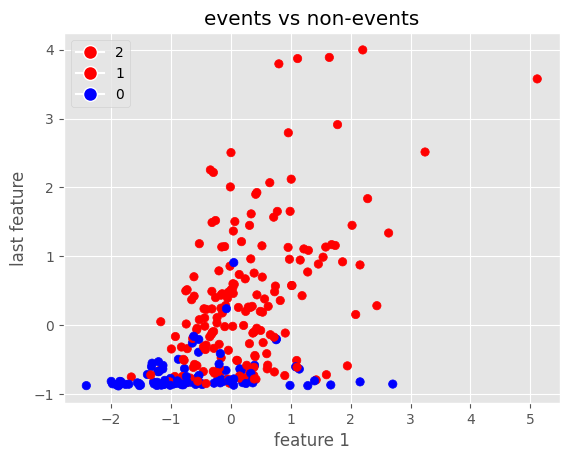

In [19]:
plt.scatter(feats_df['feature_1'], feats_df['feature_last'], c=feats_df['label'].map({2: 'red', 1: 'red', 0: 'blue'}))

plt.xlabel('feature 1')
plt.ylabel('last feature')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='2', markerfacecolor='red', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='red', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='blue', markersize=10)])

plt.title('events vs non-events')
plt.show()

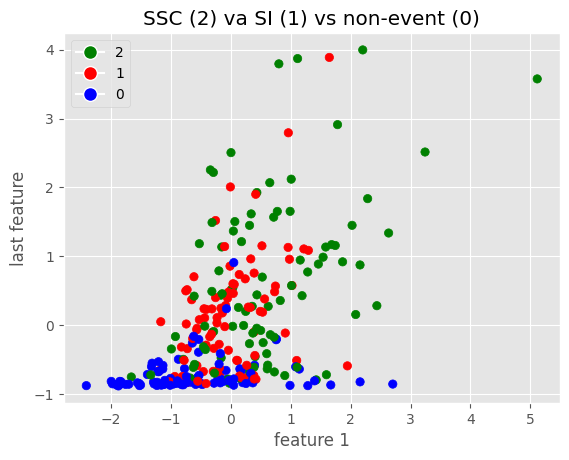

In [20]:
plt.scatter(feats_df['feature_1'], feats_df['feature_last'], c=feats_df['label'].map({2: 'green', 1: 'red', 0: 'blue'}))

plt.xlabel('feature 1')
plt.ylabel('last feature')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='2', markerfacecolor='green', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='red', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='blue', markersize=10)])

plt.title('SSC (2) va SI (1) vs non-event (0)')
plt.show()

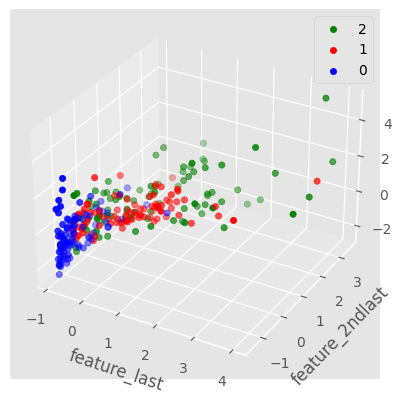

In [21]:
# columns
feat_discriminante = 'feature_last'
feat_y = 'feature_2ndlast' 
feat_z = 'feature_1'
label = 'label'


# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = {2: 'green', 1: 'red', 0: 'blue'}

for label_name, label_color in colors.items():
    subset = feats_df[feats_df[label] == label_name]
    ax.scatter(subset[feat_discriminante], subset[feat_y], subset[feat_z], c=label_color, label=label_name)

ax.set_xlabel(feat_discriminante)
ax.set_ylabel(feat_y)
ax.set_zlabel(feat_z)

ax.legend()

plt.show()


______

### Classification

#### Logistic Regression with 10-folds cross validation

In [22]:
def k_fold_cross_validation(X, y, num_folds, num_epochs, batch_size, random_seed=2):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_seed)
    fold = 0
    results = {}

    for train_index, val_index in kf.split(X):
        # get fold
        fold += 1
        print(f'\nFold {fold}/{num_folds}:')

        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]


        # define logistic regression model
        num_input = X_train.shape[-1]
        num_classes = y_train.unique().numel()
        model, optimizer, criterion = get_logistic_model(num_input, num_classes)

        # train model
        print('Training:')
        n_samples_train = X_train.shape[0]
        train_logistic_model(X_train, y_train, model, optimizer, criterion, num_epochs, n_samples_train, batch_size, verbose=True)


        # compute accuracy on validation set
        print('\nValidation:')
        resp_val = model.forward(X_val)
        avg_loss_val = criterion(resp_val, y_val)

        y_hat_val = resp_val.argmax(dim=1)
        accuracy_val = (y_val == y_hat_val).float().mean()

        print('Validation, average loss = {:1.3f}, accuracy = {:1.3f}'.format(avg_loss_val, accuracy_val))

        # other metrics
        precision = precision_score(y_val, y_hat_val, average='weighted')
        recall = recall_score(y_val, y_hat_val, average='weighted')
        f1 = f1_score(y_val, y_hat_val, average='weighted')

        results[fold] = {'model':model, 'validation_accuracy':accuracy_val.item(),
                         'precision':precision, 'recall':recall, 'F1':f1}

    return results


# 10-folds CV
num_folds = 10
num_epochs = 10
batch_size = 32
results = k_fold_cross_validation(Sx_train, y_train_resampled, num_folds, num_epochs, batch_size)


Fold 1/10:
Training:
Epoch 0, average loss = 0.763, accuracy = 0.593
Epoch 1, average loss = 0.745, accuracy = 0.617
Epoch 2, average loss = 0.713, accuracy = 0.626
Epoch 3, average loss = 0.691, accuracy = 0.654
Epoch 4, average loss = 0.677, accuracy = 0.663
Epoch 5, average loss = 0.663, accuracy = 0.663
Epoch 6, average loss = 0.651, accuracy = 0.679
Epoch 7, average loss = 0.641, accuracy = 0.687
Epoch 8, average loss = 0.632, accuracy = 0.691
Epoch 9, average loss = 0.623, accuracy = 0.691

Validation:
Validation, average loss = 0.603, accuracy = 0.667

Fold 2/10:
Training:
Epoch 0, average loss = 0.821, accuracy = 0.584
Epoch 1, average loss = 0.786, accuracy = 0.613
Epoch 2, average loss = 0.747, accuracy = 0.630
Epoch 3, average loss = 0.719, accuracy = 0.646
Epoch 4, average loss = 0.702, accuracy = 0.654
Epoch 5, average loss = 0.693, accuracy = 0.650
Epoch 6, average loss = 0.681, accuracy = 0.667
Epoch 7, average loss = 0.670, accuracy = 0.675
Epoch 8, average loss = 0.66

In [23]:
results

{1: {'model': Sequential(
    (0): Linear(in_features=235, out_features=3, bias=True)
    (1): LogSoftmax(dim=1)
  ),
  'validation_accuracy': 0.6666666865348816,
  'precision': 0.711894586894587,
  'recall': 0.6666666666666666,
  'F1': 0.6813186813186812},
 2: {'model': Sequential(
    (0): Linear(in_features=235, out_features=3, bias=True)
    (1): LogSoftmax(dim=1)
  ),
  'validation_accuracy': 0.7407407164573669,
  'precision': 0.7207977207977208,
  'recall': 0.7407407407407407,
  'F1': 0.7246913580246915},
 3: {'model': Sequential(
    (0): Linear(in_features=235, out_features=3, bias=True)
    (1): LogSoftmax(dim=1)
  ),
  'validation_accuracy': 0.7777777910232544,
  'precision': 0.78998778998779,
  'recall': 0.7777777777777778,
  'F1': 0.7721216691804927},
 4: {'model': Sequential(
    (0): Linear(in_features=235, out_features=3, bias=True)
    (1): LogSoftmax(dim=1)
  ),
  'validation_accuracy': 0.6666666865348816,
  'precision': 0.758056758056758,
  'recall': 0.666666666666666

In [24]:
acc, precision, recall, f1 = 0, 0, 0, 0

for k in results.keys():
    acc += results[k]['validation_accuracy']
    precision += results[k]['precision']
    recall += results[k]['recall']
    f1 += results[k]['F1']

print('Average accuracy (10-folds Cross-Validation): {}'.format(acc/num_folds))
print('Average precision (10-folds Cross-Validation): {}'.format(precision/num_folds))
print('Average recall (10-folds Cross-Validation): {}'.format(recall/num_folds))
print('Average F1 (10-folds Cross-Validation): {}'.format(f1/num_folds))

Average accuracy (10-folds Cross-Validation): 0.6666666686534881
Average precision (10-folds Cross-Validation): 0.7012455754122421
Average recall (10-folds Cross-Validation): 0.6666666666666667
Average F1 (10-folds Cross-Validation): 0.6598146328693285


In [25]:
max_recall = 0
for k in results.keys():
    if results[k]['recall'] > max_recall:
        max_recall = results[k]['recall']
        new_best_model = k

# model with highest recall
print('model with highest recall: fold {}, recall {}'.format(new_best_model, 
                                                             results[new_best_model]['recall'] ))

model with highest recall: fold 3, recall 0.7777777777777778


In [26]:
best_model = results[new_best_model]['model']
criterion = torch.nn.NLLLoss() # negative log likelihood loss

# TEST SET
# accuracy
resp = best_model.forward(Sx_test)
avg_loss = criterion(resp, y_test)

y_hat = resp.argmax(dim=1)
acc = (y_test == y_hat).float().mean()

print('Model accuracy: ', acc.item())

# confusion matrix
preds_test = y_hat.numpy()
true_test = y_test.numpy()
confusion = confusion_matrix(true_test, preds_test)

# probabilities of class assignment
best_model.eval() 
with torch.no_grad():
    logits = best_model(Sx_test)
    probs = torch.softmax(logits, dim=1)

Model accuracy:  0.6914893388748169


In [27]:
probs

tensor([[1.3036e-02, 2.1722e-01, 7.6974e-01],
        [1.0132e-02, 1.8682e-01, 8.0305e-01],
        [4.6018e-02, 3.4617e-01, 6.0781e-01],
        [1.7888e-02, 2.1397e-01, 7.6814e-01],
        [2.0571e-01, 5.1776e-01, 2.7653e-01],
        [9.7576e-01, 1.1122e-02, 1.3114e-02],
        [2.0173e-01, 3.4474e-01, 4.5353e-01],
        [1.3892e-02, 1.8295e-01, 8.0316e-01],
        [9.7369e-01, 2.0333e-02, 5.9764e-03],
        [1.3876e-02, 1.7710e-01, 8.0902e-01],
        [2.4993e-01, 2.4846e-01, 5.0161e-01],
        [2.3175e-03, 3.4216e-01, 6.5552e-01],
        [2.4209e-03, 1.3937e-01, 8.5821e-01],
        [6.6160e-02, 3.0669e-01, 6.2715e-01],
        [7.3509e-01, 1.9842e-01, 6.6482e-02],
        [2.6391e-01, 3.8202e-01, 3.5407e-01],
        [3.8729e-02, 2.3572e-01, 7.2555e-01],
        [8.6389e-01, 9.1681e-02, 4.4433e-02],
        [9.9353e-01, 2.2341e-03, 4.2361e-03],
        [7.7755e-02, 3.2163e-01, 6.0062e-01],
        [1.3388e-02, 1.7607e-01, 8.1055e-01],
        [6.2180e-01, 2.4149e-01, 1

In [28]:
confusion

array([[27,  1,  2],
       [ 5,  6, 10],
       [ 2,  9, 32]])

In [29]:
Counter(y_test.numpy())

Counter({2: 43, 0: 30, 1: 21})

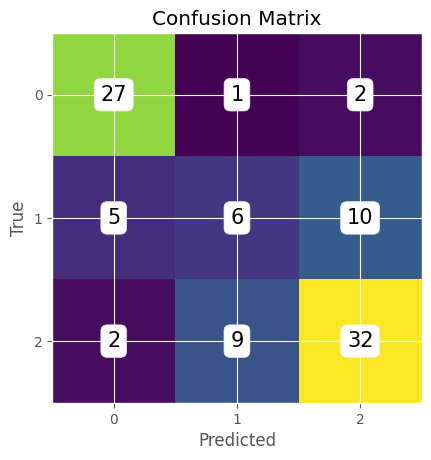

In [30]:
def plot_confusion_matrix(confusion):
    plt.figure()
    plt.imshow(confusion, cmap='viridis') 

    num_classes = confusion.shape[0]
    tick_locs = np.arange(num_classes)
    ticks = ['{}'.format(i) for i in range(num_classes)]

    plt.xticks(tick_locs, ticks)
    plt.yticks(tick_locs, ticks)

    plt.ylabel('True')
    plt.xlabel('Predicted')

    for i in range(num_classes):
        for j in range(num_classes):
            lab = f'{confusion[i, j]}'

            plt.text(j, i, lab, ha='center', va='center', color='black', fontsize=15, bbox=dict(boxstyle='round', fc='w'))

    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(confusion)


In [31]:
lab_to_int # SI have the most problematic prediction

{'non-event': 0, 'SI': 1, 'SSC': 2}

In [32]:
precision = precision_score(true_test, preds_test, average='weighted')
recall = recall_score(true_test, preds_test, average='weighted')
f1 = f1_score(true_test, preds_test, average='weighted')

print('Precision: {}\nRecall: {}\nF1: {}'.format(precision,recall,f1))

Precision: 0.6699069860052338
Recall: 0.6914893617021277
F1: 0.6782499438176254


In [33]:
print('\t\tNon-Event (0)  SI (1)  SSC (2)\nPrecision:\t{}\nRecall:\t\t{}\nF1:\t\t{}'.format(
                                                                                    precision_score(true_test, preds_test, average=None),
                                                                                    recall_score(true_test, preds_test, average=None),
                                                                                    f1_score(true_test, preds_test, average=None)))

		Non-Event (0)  SI (1)  SSC (2)
Precision:	[0.79411765 0.375      0.72727273]
Recall:		[0.9        0.28571429 0.74418605]
F1:		[0.84375    0.32432432 0.73563218]


In [34]:
acc_log_reg_full = accuracy_score(true_test, preds_test)

In [35]:
precision_log_reg_full, recall_log_reg_full, f1_score_log_reg_full, support_log_reg_full = precision_recall_fscore_support(true_test, preds_test)
precision_log_reg_full, recall_log_reg_full, f1_score_log_reg_full, support_log_reg_full 

(array([0.79411765, 0.375     , 0.72727273]),
 array([0.9       , 0.28571429, 0.74418605]),
 array([0.84375   , 0.32432432, 0.73563218]),
 array([30, 21, 43]))

#### Support Vector Classifier with Grid Search and 10-folds cross validation

In [36]:
# SVC parameters
param_grid = { 
        'C': [ 0.1,  1. , 2., 10. ], # regularization
        'class_weight':[{0:1, 1:2.2, 2:1},
                        {0:1, # class : weight
                         1:2, # give weight 2 to class 1 (SI event), and weight 1 to the other two, since SI are the most misclassified
                         2:1},  
                        {0:1, 1:1.5, 2:1.2},
                        {0:1, 1:2, 2:1.5}
                        ],
        'kernel': ['poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto'] # kernel coefficent for poly, rbf, sigmoid
        }


# 10 folds CV
n_splits, n_repeats = 10, 5
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=2)
grid_search = GridSearchCV(estimator=SVC(), 
                            param_grid=param_grid, 
                            scoring='accuracy', 
                            refit='accuracy', 
                            n_jobs=-1, 
                            cv=cv)
gridCV = grid_search.fit(Sx_train, y_train_resampled)
gridCV.best_params_

{'C': 10.0,
 'class_weight': {0: 1, 1: 2.2, 2: 1},
 'gamma': 'auto',
 'kernel': 'rbf'}

In [37]:
svc = SVC(**gridCV.best_params_, probability=True).fit(Sx_train, y_train_resampled)

In [38]:
svm_preds = svc.predict(Sx_test)
confusion = confusion_matrix(y_test, svm_preds)
confusion

array([[28,  2,  0],
       [ 3, 13,  5],
       [ 3,  9, 31]])

In [39]:
# probabilities class assignment
svc_probs = svc.predict_proba(Sx_test)
svc_probs

array([[1.16633281e-02, 3.10845097e-01, 6.77491575e-01],
       [6.24340640e-03, 4.35590929e-02, 9.50197501e-01],
       [1.32216846e-02, 7.42241083e-01, 2.44537232e-01],
       [5.36427150e-03, 2.17140566e-01, 7.77495162e-01],
       [6.28029855e-01, 2.28835626e-01, 1.43134518e-01],
       [8.92270920e-01, 6.01914241e-03, 1.01709937e-01],
       [1.60883971e-01, 4.54892056e-01, 3.84223973e-01],
       [8.82761470e-03, 3.76854112e-02, 9.53486974e-01],
       [9.87300907e-01, 1.92346530e-03, 1.07756275e-02],
       [3.51739403e-03, 1.50541774e-02, 9.81428429e-01],
       [5.30801437e-02, 1.71312120e-01, 7.75607737e-01],
       [1.94051567e-03, 3.42188780e-02, 9.63840606e-01],
       [1.28870673e-02, 6.48838454e-02, 9.22229087e-01],
       [2.98790571e-02, 5.72420020e-01, 3.97700922e-01],
       [8.31003216e-01, 6.55725523e-02, 1.03424231e-01],
       [8.44186247e-02, 7.04132987e-01, 2.11448389e-01],
       [5.71517429e-03, 9.59993559e-02, 8.98285470e-01],
       [9.85924225e-01, 8.19636

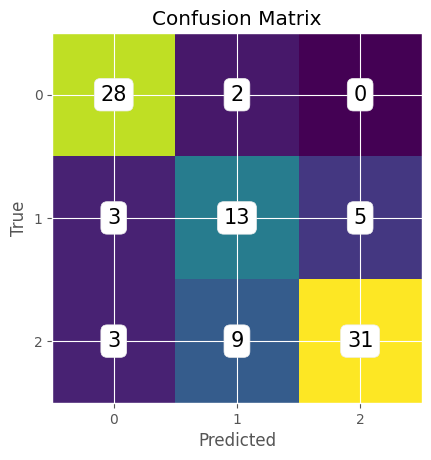

In [40]:
plot_confusion_matrix(confusion)

In [41]:
print('Accuracy on Test Set: {}'.format(accuracy_score(y_test, svm_preds)))

Accuracy on Test Set: 0.7659574468085106


In [42]:
precision = precision_score(y_test, svm_preds, average='weighted')
recall = recall_score(y_test, svm_preds, average='weighted')
f1 = f1_score(y_test, svm_preds, average='weighted')

print('Precision: {}\nRecall: {}\nF1: {}'.format(precision,recall,f1))

Precision: 0.7777517035182868
Recall: 0.7659574468085106
F1: 0.7673422210252266


In [43]:
print('\t\tNon-Event (0)  SI (1)  SSC (2)\nPrecision:\t{}\nRecall:\t\t{}\nF1:\t\t{}'.format(
                                                                                    precision_score(y_test, svm_preds, average=None),
                                                                                    recall_score(y_test, svm_preds, average=None),
                                                                                    f1_score(y_test, svm_preds, average=None)))

		Non-Event (0)  SI (1)  SSC (2)
Precision:	[0.82352941 0.54166667 0.86111111]
Recall:		[0.93333333 0.61904762 0.72093023]
F1:		[0.875      0.57777778 0.78481013]


In [44]:
print(classification_report(y_test, svm_preds))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87        30
           1       0.54      0.62      0.58        21
           2       0.86      0.72      0.78        43

    accuracy                           0.77        94
   macro avg       0.74      0.76      0.75        94
weighted avg       0.78      0.77      0.77        94



In [45]:
acc_svc_full = accuracy_score(y_test, svm_preds)
precision_svc_full, recall_svc_full, f1_score_svc_full, support_svc_full = precision_recall_fscore_support(y_test, svm_preds)
precision_svc_full, recall_svc_full, f1_score_svc_full, support_svc_full

(array([0.82352941, 0.54166667, 0.86111111]),
 array([0.93333333, 0.61904762, 0.72093023]),
 array([0.875     , 0.57777778, 0.78481013]),
 array([30, 21, 43]))

#### Random Forest with Grid Search opt and 10 folds CV

In [46]:
rf_classifier = RandomForestClassifier(random_state=2)

param_grid = {
    'n_estimators': [50, 100, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# 10 folds CV
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2)

# grid search with 10-fold cross-validation
grid_search_rf = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           cv=cv)
grid_search_rf.fit(Sx_train.numpy(), y_train_resampled.numpy()) # must be numpy array

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
             estimator=RandomForestClassifier(random_state=2), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [47]:
grid_search_rf.best_params_

{'bootstrap': False,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

In [48]:
# best accuracy score
grid_search_rf.best_score_

0.7851851851851851

In [49]:
rf = RandomForestClassifier(**grid_search_rf.best_params_, random_state=2).fit(Sx_train.numpy(), y_train_resampled.numpy())

In [50]:
y_pred_rf = rf.predict(Sx_test.numpy())
acc_rf_full = accuracy_score(y_test.numpy(), y_pred_rf)
print('Test Accuracy: ', acc_rf_full)

Test Accuracy:  0.7446808510638298


In [51]:
# get probabilities
probs_random_forest = rf.predict_proba(Sx_test.numpy())

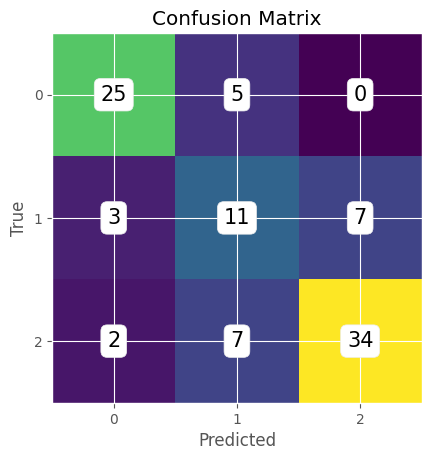

In [52]:
confusion_rf = confusion_matrix(y_test.numpy(), y_pred_rf)
plot_confusion_matrix(confusion_rf)

In [53]:
print(classification_report(y_test.numpy(), y_pred_rf))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        30
           1       0.48      0.52      0.50        21
           2       0.83      0.79      0.81        43

    accuracy                           0.74        94
   macro avg       0.71      0.72      0.71        94
weighted avg       0.75      0.74      0.75        94



In [54]:
precision_rf_full, recall_rf_full, f1_score_rf_full, support_rf_full = precision_recall_fscore_support(y_test.numpy(), y_pred_rf)
precision_rf_full, recall_rf_full, f1_score_rf_full, support_rf_full 

(array([0.83333333, 0.47826087, 0.82926829]),
 array([0.83333333, 0.52380952, 0.79069767]),
 array([0.83333333, 0.5       , 0.80952381]),
 array([30, 21, 43]))

In [55]:
precision_rf = precision_score(y_test.numpy(), y_pred_rf, average='weighted')
recall_rf = recall_score(y_test.numpy(), y_pred_rf, average='weighted')
f1_rf = f1_score(y_test.numpy(), y_pred_rf, average='weighted')

print('Precision: {}\nRecall: {}\nF1: {}'.format(precision_rf, recall_rf, f1_rf))

Precision: 0.7521490941088874
Recall: 0.7446808510638298
F1: 0.7479736575481256


_______

### Features Selection: 
### Classification selecting only most important features via Random Forest Gini-Importance

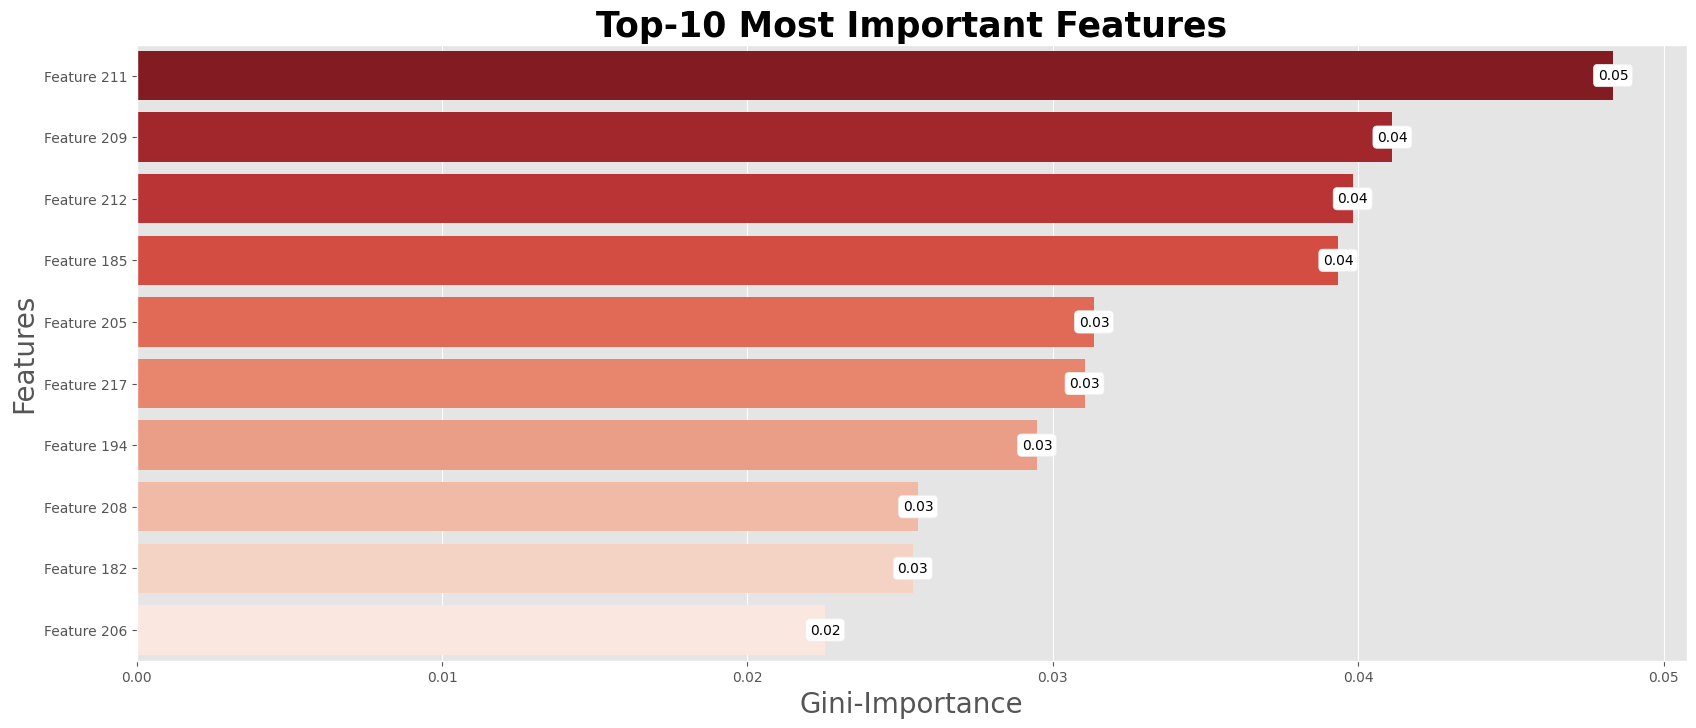

In [56]:
Sc_all_df = pd.DataFrame(Sx_train)

rf = RandomForestClassifier(max_depth=3, random_state=2)
rf.fit(Sc_all_df, y_train_resampled)

# check which features are the most important in the random forest model
feats = {}
for feature, importance in zip(Sc_all_df.columns, rf.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})


# Plot most important features
top_10 = importances[:10]
top_10['Features'] = top_10.Features.astype('str')
top_10['Features'] = ['Feature '+f for f in top_10.Features]

plt.figure(figsize=(20,8))
sns.barplot(x=top_10['Gini-Importance'], y=top_10['Features'], data=top_10,  palette='Reds_r')
plt.xlabel('Gini-Importance', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.title('Top-10 Most Important Features', fontsize=25, weight = 'bold')

i=1
for p in top_10['Gini-Importance']:
    xx = p
    yy = i-1
    lab = round(p, 2)
    plt.annotate(lab, (xx, yy), 
                bbox=dict(boxstyle='round', fc='w'), 
                va='center', ha='center')
    i+=1

plt.show()

In [57]:
importances['Cumulative-Importance'] = importances['Gini-Importance'].cumsum()
importances

,Features,Gini-Importance,Cumulative-Importance
0,211,0.048344,0.048344
1,209,0.041121,0.089466
2,212,0.039820,0.129286
3,185,0.039349,0.168635
4,205,0.031349,0.199985
...,...,...,...
230,97,0.000000,1.000000
231,99,0.000000,1.000000
232,176,0.000000,1.000000
233,100,0.000000,1.000000


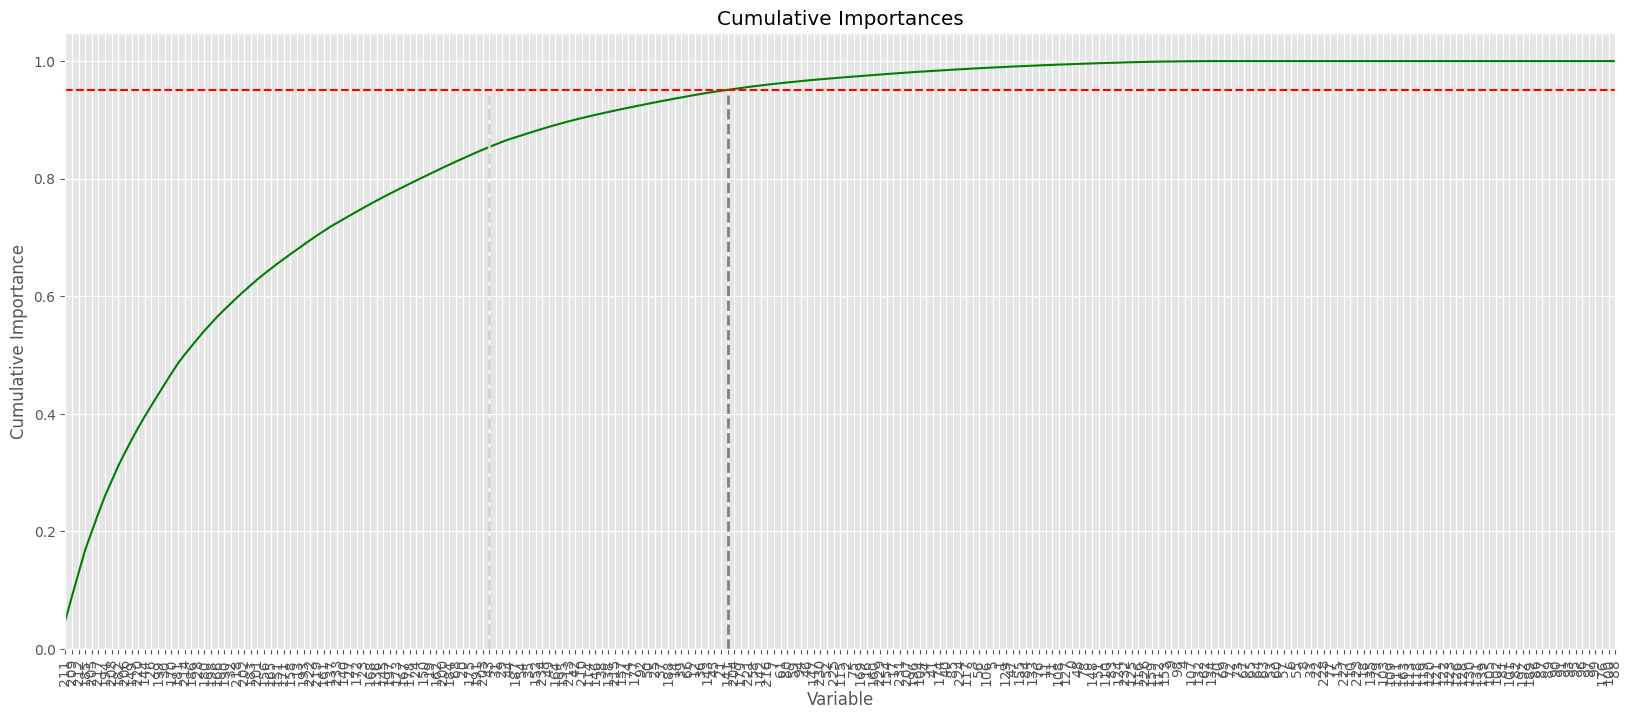

In [58]:
# cumulative importance
cumulative_importances = np.cumsum(importances['Gini-Importance'])

plt.figure(figsize=(20,8))

plt.plot(Sc_all_df.columns, cumulative_importances, 'g-')

# draw line at 95% of importance:
plt.hlines(y = 0.95, xmin=0, xmax=len(importances['Features']), color='r', linestyles='dashed')

# top 10 feats

plt.axvline(x=np.argmax(cumulative_importances >= 0.85), # 85% Gini-Importance reached
            ymin=0, ymax=.9, color='lightgray', linestyle='dashed', linewidth=2)
plt.axvline(x=np.argmax(cumulative_importances >= 0.95), # 95% Gini-Importance reached
            ymin=0, ymax=.9, color='gray', linestyle='dashed', linewidth=2)


plt.xticks(Sc_all_df.columns, importances['Features'], rotation = 'vertical')
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importances')

plt.xlim(xmin=0, xmax=len(importances['Features']) - 1)
plt.ylim(ymin=0)

plt.show()

In [59]:
# find the index where cumulative importance first reaches or exceeds 0.95 (in RF)
print('Keep', importances[importances['Cumulative-Importance'] >= 0.95].index[0] + 1, 'out of', len(importances), 'features')

Keep 101 out of 235 features


In [60]:
# index where cumulative importance first reaches or exceeds 0.95 
index_to_cut = importances[importances['Cumulative-Importance'] >= 0.95].index[0]

cut_importances = importances.iloc[:index_to_cut + 1]

col_impo_feats = cut_importances.Features.to_list()
reduced_Sc_all = Sx_train[:, col_impo_feats]
reduced_Sc_all # train set with only most importance features according to Gini-Importance

tensor([[ 1.0477e+00,  8.4002e-01,  1.8029e+00,  ...,  1.0176e+00,
          1.3465e+00,  1.4347e+00],
        [-2.7945e-01, -2.3928e-01, -5.2201e-02,  ..., -2.2492e-02,
          4.1462e-01, -9.1605e-01],
        [-2.3046e-01,  1.3802e-01,  6.3909e-02,  ...,  7.3923e-01,
         -1.2323e-01,  5.8916e-01],
        ...,
        [-9.7445e-01, -1.5391e+00, -9.3001e-01,  ..., -1.1670e+00,
         -1.1500e+00, -1.6215e+00],
        [-2.5292e-01, -1.0301e-01,  3.9708e-01,  ..., -7.0653e-01,
          2.9384e-01,  1.7778e-03],
        [-1.1246e-01, -6.0011e-01, -3.2464e-01,  ..., -1.4806e+00,
          3.8173e-01,  1.1447e+00]])

In [61]:
np.shape(reduced_Sc_all)

torch.Size([270, 101])

In [62]:
len(y_train_resampled)

270

#### Visualization

In [63]:
# TOP 3 VISUALIZATION
top_3_feats = col_impo_feats[:3]
feats_df = pd.DataFrame(Sx_train[:, top_3_feats], columns=[str(feat) for feat in top_3_feats])
feats_df['label'] = y_train_resampled
feats_df

,211,209,212,label
0,1.047730,0.840021,1.802920,1
1,-0.279450,-0.239281,-0.052201,2
2,-0.230463,0.138016,0.063909,0
3,-1.672574,-1.601906,-1.680905,0
4,-0.191114,-0.079518,-0.283695,2
...,...,...,...,...
265,-0.495824,-0.229736,0.094751,1
266,0.663186,0.383362,0.645460,1
267,-0.974446,-1.539097,-0.930014,0
268,-0.252922,-0.103007,0.397076,1


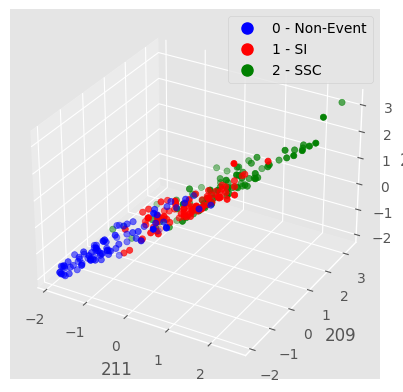

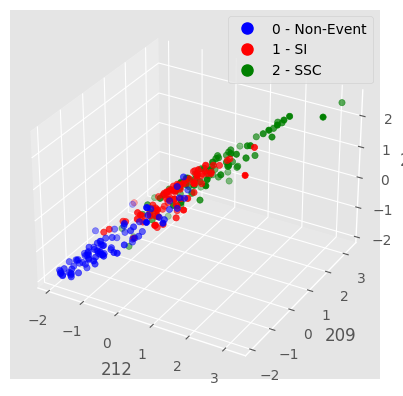

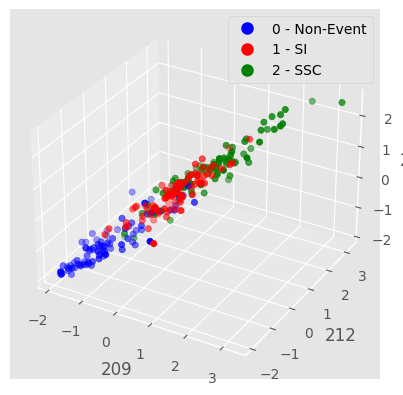

In [64]:
def plot_3D_feats(feat_discriminante, feat_y, feat_z, label):
    # 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    colors = {2: 'green', 1: 'red', 0: 'blue'}

    for label_name, label_color in colors.items():
        subset = feats_df[feats_df[label] == label_name]
        ax.scatter(subset[feat_discriminante], subset[feat_y], subset[feat_z], c=label_color, label=label_name)

    ax.set_xlabel(feat_discriminante)
    ax.set_ylabel(feat_y)
    ax.set_zlabel(feat_z)

    # legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='blue', label='0 - Non-Event', markersize=8, linestyle='None'),
        plt.Line2D([0], [0], marker='o', color='red', label='1 - SI', markersize=8, linestyle='None'),
        plt.Line2D([0], [0], marker='o', color='green', label='2 - SSC', markersize=8, linestyle='None')
    ]

    ax.legend(handles=legend_elements)

    plt.show()

plot_3D_feats(feat_discriminante = feats_df.columns[0], 
            feat_y = feats_df.columns[1],
            feat_z = feats_df.columns[2],
            label = 'label')

plot_3D_feats(feat_discriminante = feats_df.columns[2],
            feat_y = feats_df.columns[1],
            feat_z = feats_df.columns[0],
            label = 'label')
plot_3D_feats(feat_discriminante = feats_df.columns[1],
            feat_y = feats_df.columns[2],
            feat_z = feats_df.columns[0],
            label = 'label')

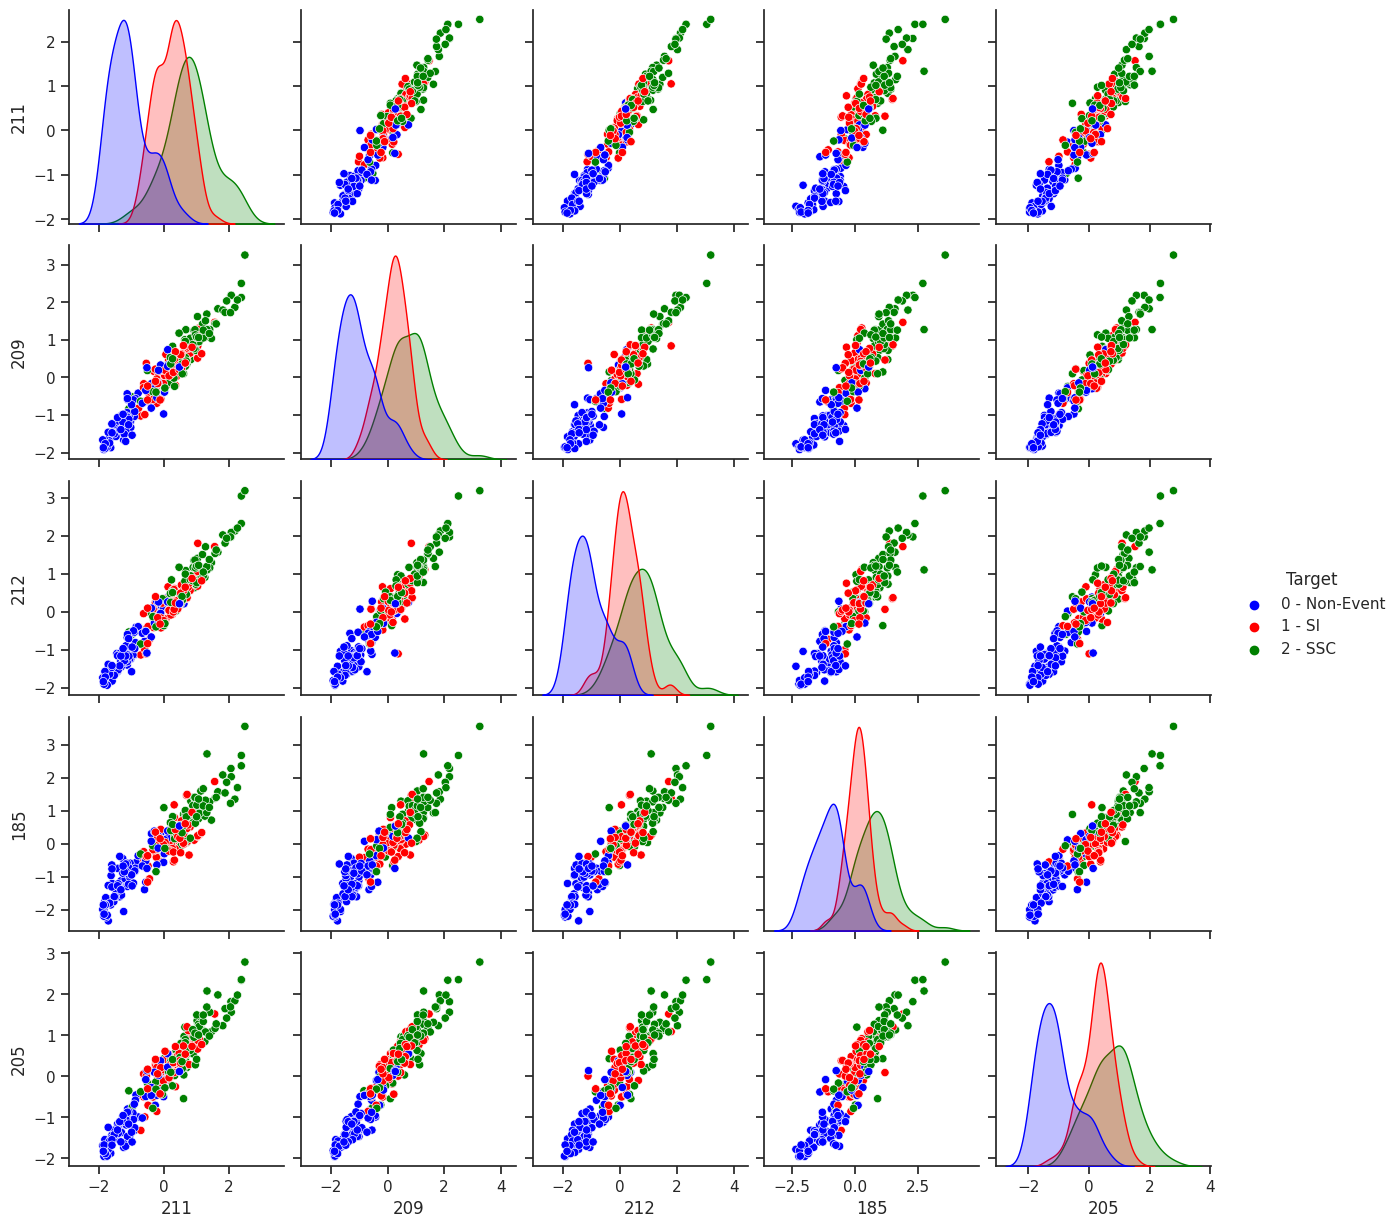

In [65]:
feature_importances = rf.feature_importances_

# select most important features
num_feats_to_select = 5
top_feats_index = np.argsort(feature_importances)[::-1][:num_feats_to_select]
top_feats_names = top_feats_index # columns names are num from 0

# df with feats and target
data_to_plot = Sc_all_df.loc[:, top_feats_index]
data_to_plot['Target'] = y_train_resampled
data_to_plot['Target'] = data_to_plot['Target'].replace({0: '0 - Non-Event', 1: '1 - SI', 2:'2 - SSC'})

# pairwise plot
sns.set(style='ticks', font_scale=1)
pairplot = sns.pairplot(data_to_plot, hue='Target', diag_kind='kde', # palette={0: 'blue', 1: 'red', 2: 'green'})
                        palette={'0 - Non-Event':'blue', 
                                 '1 - SI':'red', 
                                 '2 - SSC':'green'},
                        hue_order = ['0 - Non-Event', '1 - SI', '2 - SSC'])

# add legend
# handles = pairplot._legend_data.values()
# labels = ['0 - Non-Event', '1 - SI', '2 - SSC'] # pairplot._legend_data.keys()
# pairplot.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=3, prop={'size': 15})
# pairplot.fig.subplots_adjust(top=0.95, bottom=0.0)

plt.show()


In [66]:
plt.style.use('ggplot')

Explained variation per principal component: [0.84963715 0.04981716 0.0176135  0.01311863]


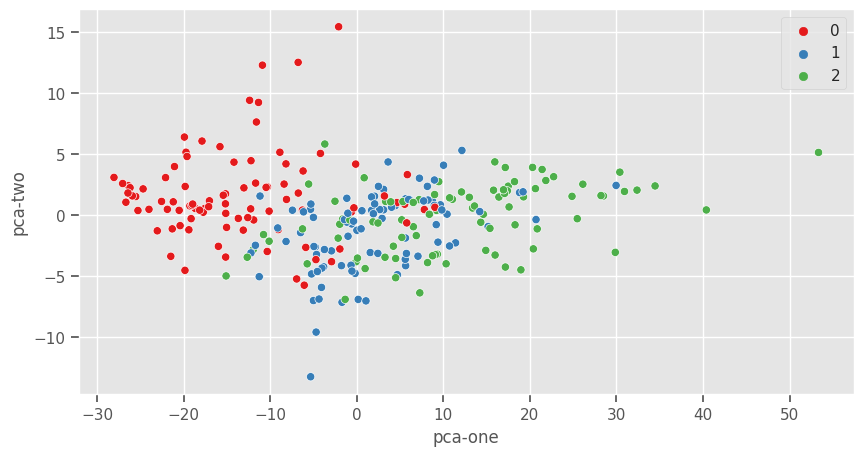

{'non-event': 0, 'SI': 1, 'SSC': 2}


In [67]:
Sc_all_df = pd.DataFrame(Sx_train)

# PCA 
num_pc = 4
pca = PCA(n_components=num_pc) 
pca_result = pca.fit_transform(Sc_all_df) 

# put PC in feats_df 
feats['pca-one'] = pca_result[:,0]
feats['pca-two'] = pca_result[:,1] 
feats['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# plot scatterplot of first PC on x axis and second PC on y axis
plt.figure(figsize=(10,5))
sns.scatterplot( 
    x='pca-one', 
    y='pca-two',
    hue=y_train_resampled, 
    palette=sns.color_palette('Set1', 3),
    data=feats,
    legend='full')
plt.show()
print(lab_to_int)

In [68]:
np.cumsum(pca.explained_variance_ratio_)

array([0.84963715, 0.8994543 , 0.91706777, 0.9301864 ], dtype=float32)

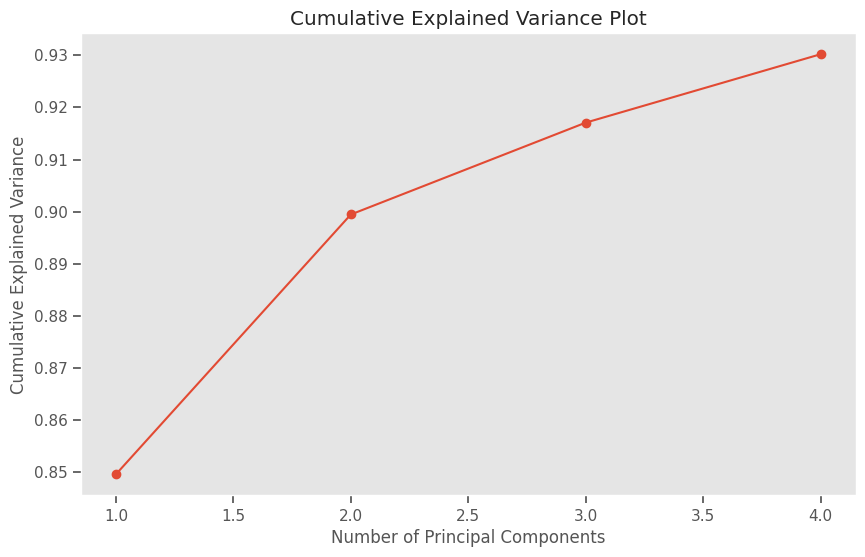

In [69]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.grid()
plt.show()

#### Logistic regression with 10-folds CV on REDUCED set of features

In [70]:
# Logistic regression with 10-folds CV on reduced set of features
num_folds = 10
num_epochs = 10
batch_size = 32
results_reduced = k_fold_cross_validation(reduced_Sc_all, y_train_resampled, num_folds, num_epochs, batch_size)


Fold 1/10:
Training:
Epoch 0, average loss = 0.895, accuracy = 0.580
Epoch 1, average loss = 0.779, accuracy = 0.597
Epoch 2, average loss = 0.746, accuracy = 0.605
Epoch 3, average loss = 0.734, accuracy = 0.597
Epoch 4, average loss = 0.727, accuracy = 0.613
Epoch 5, average loss = 0.719, accuracy = 0.626
Epoch 6, average loss = 0.712, accuracy = 0.638
Epoch 7, average loss = 0.704, accuracy = 0.634
Epoch 8, average loss = 0.697, accuracy = 0.646
Epoch 9, average loss = 0.690, accuracy = 0.658

Validation:
Validation, average loss = 0.664, accuracy = 0.704

Fold 2/10:
Training:
Epoch 0, average loss = 0.905, accuracy = 0.576
Epoch 1, average loss = 0.793, accuracy = 0.597
Epoch 2, average loss = 0.760, accuracy = 0.597
Epoch 3, average loss = 0.749, accuracy = 0.593
Epoch 4, average loss = 0.741, accuracy = 0.613
Epoch 5, average loss = 0.734, accuracy = 0.630
Epoch 6, average loss = 0.727, accuracy = 0.634
Epoch 7, average loss = 0.720, accuracy = 0.638
Epoch 8, average loss = 0.71

In [71]:
acc, precision, recall, f1 = 0, 0, 0, 0

for k in results_reduced.keys():
    acc += results_reduced[k]['validation_accuracy']
    precision += results_reduced[k]['precision']
    recall += results_reduced[k]['recall']
    f1 += results_reduced[k]['F1']

print('Average accuracy (10-folds Cross-Validation): {}'.format(acc/num_folds))
print('Average precision (10-folds Cross-Validation): {}'.format(precision/num_folds))
print('Average recall (10-folds Cross-Validation): {}'.format(recall/num_folds))
print('Average F1 (10-folds Cross-Validation): {}'.format(f1/num_folds))

Average accuracy (10-folds Cross-Validation): 0.6333333373069763
Average precision (10-folds Cross-Validation): 0.6806059938004383
Average recall (10-folds Cross-Validation): 0.6333333333333334
Average F1 (10-folds Cross-Validation): 0.6027884137354347


In [72]:
max_recall = 0
for k in results_reduced.keys():
    if results_reduced[k]['recall'] > max_recall:
        max_recall = results_reduced[k]['recall']
        new_best_model = k

# model with highest recall
print('model with highest recall: fold {}, recall {}'.format(new_best_model, 
                                                             results_reduced[new_best_model]['recall'] ))

model with highest recall: fold 1, recall 0.7037037037037037


In [73]:
best_model = results_reduced[new_best_model]['model']
criterion = torch.nn.NLLLoss() # negative log likelihood loss

# TEST SET
# accuracy
reduced_test = Sx_test[:, col_impo_feats]

resp = best_model.forward(reduced_test)
avg_loss = criterion(resp, y_test)

y_hat = resp.argmax(dim=1)
acc = (y_test == y_hat).float().mean()

print('Model accuracy: ', acc.item())

# confusion matrix
preds_test = y_hat.numpy()
true_test = y_test.numpy()
confusion = confusion_matrix(true_test, preds_test)

# probabilities of class assignment
best_model.eval() 
with torch.no_grad():
    logits = best_model(reduced_test)
    probs = torch.softmax(logits, dim=1)

Model accuracy:  0.6914893388748169


In [74]:
acc_log_reg_reduced = accuracy_score(true_test, preds_test)

In [75]:
precision_log_reg_reduced, recall_log_reg_reduced, f1_score_log_reg_reduced, support_log_reg_reduced = precision_recall_fscore_support(true_test, preds_test)
precision_log_reg_reduced, recall_log_reg_reduced, f1_score_log_reg_reduced, support_log_reg_reduced

(array([0.77142857, 0.33333333, 0.7       ]),
 array([0.9       , 0.14285714, 0.81395349]),
 array([0.83076923, 0.2       , 0.75268817]),
 array([30, 21, 43]))

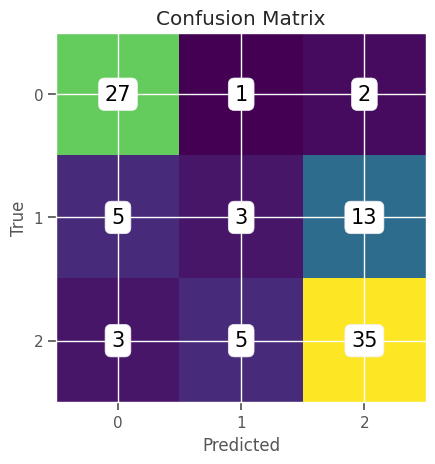

In [76]:
plot_confusion_matrix(confusion)

#### SVC with Grid Search and 10 folds CV on REDUCED feature matrix

In [77]:
# SVC parameters
param_grid = { 
        'C': [ 0.1,  1. , 2., 10. ], # regularization
        'class_weight':[{0:1, 1:2.2, 2:1},
                        {0:1, # class : weight
                         1:2, # give weight 2 to class 1 (SI event), and weight 1 to the other two, since SI are the most misclassified
                         2:1},  
                        {0:1, 1:1.5, 2:1.2},
                        {0:1, 1:2, 2:1.5}
                        ],
        'kernel': ['poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto'] # kernel coefficent for poly, rbf, sigmoid
        }


# 10 folds CV
n_splits, n_repeats = 10, 5
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=2)
grid_search = GridSearchCV(estimator=SVC(), 
                            param_grid=param_grid, 
                            scoring='accuracy', 
                            refit='accuracy', 
                            n_jobs=-1, 
                            cv=cv)
gridCV = grid_search.fit(reduced_Sc_all, y_train_resampled)
gridCV.best_params_

{'C': 10.0,
 'class_weight': {0: 1, 1: 2, 2: 1.5},
 'gamma': 'auto',
 'kernel': 'rbf'}

In [78]:
svc_reduced = SVC(**gridCV.best_params_, probability=True).fit(reduced_Sc_all, y_train_resampled)

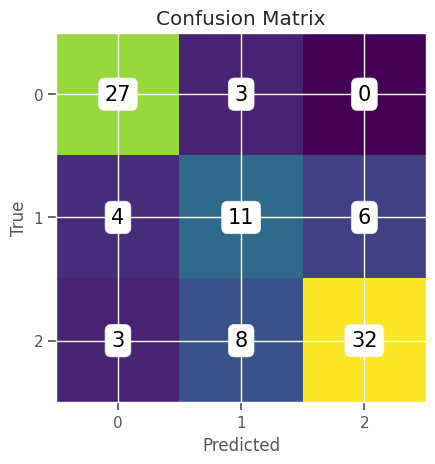

In [79]:
svm_preds = svc_reduced.predict(reduced_test)
confusion = confusion_matrix(y_test, svm_preds)
plot_confusion_matrix(confusion)

In [80]:
precision_svc_reduced, recall_svc_reduced, f1_score_svc_reduced, support_svc_reduced = precision_recall_fscore_support(y_test, svm_preds)
precision_svc_reduced, recall_svc_reduced, f1_score_svc_reduced, support_svc_reduced 

(array([0.79411765, 0.5       , 0.84210526]),
 array([0.9       , 0.52380952, 0.74418605]),
 array([0.84375   , 0.51162791, 0.79012346]),
 array([30, 21, 43]))

In [81]:
acc_svc_reduced = accuracy_score(y_test, svm_preds)

In [82]:
print('Accuracy on Test Set: {}'.format(accuracy_score(y_test, svm_preds)))

precision = precision_score(y_test, svm_preds, average='weighted')
recall = recall_score(y_test, svm_preds, average='weighted')
f1 = f1_score(y_test, svm_preds, average='weighted')

print('Precision: {}\nRecall: {}\nF1: {}'.format(precision,recall,f1))

Accuracy on Test Set: 0.7446808510638298
Precision: 0.7503622949739805
Recall: 0.7446808510638298
F1: 0.7450212200902865


In [83]:
print(classification_report(y_test, svm_preds))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        30
           1       0.50      0.52      0.51        21
           2       0.84      0.74      0.79        43

    accuracy                           0.74        94
   macro avg       0.71      0.72      0.72        94
weighted avg       0.75      0.74      0.75        94



#### Random Forest on REDUCED feature matrix

In [84]:
rrf_classifier = RandomForestClassifier(random_state=2)

param_grid = {
    'n_estimators': [50, 100, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# 10 folds CV
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2)

# grid search with 10-fold cross-validation
grid_search_rrf = GridSearchCV(estimator=rrf_classifier, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           cv=cv)
grid_search_rrf.fit(reduced_Sc_all.numpy(), y_train_resampled.numpy()) # must be numpy array


# train
rrf = RandomForestClassifier(**grid_search_rrf.best_params_, random_state=2).fit(reduced_Sc_all.numpy(), y_train_resampled.numpy())
# prediced
y_pred_rf = rrf.predict(reduced_test.numpy())


In [85]:
grid_search_rrf.best_params_

{'bootstrap': False,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

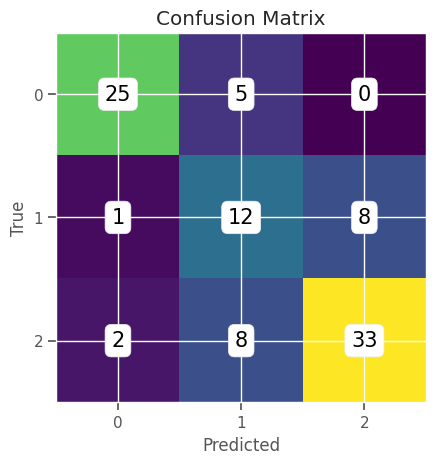

In [86]:
confusion_rrf = confusion_matrix(y_test.numpy(), y_pred_rf)
plot_confusion_matrix(confusion_rrf)

In [87]:
print('Test Accuracy:')
accuracy_score(y_test.numpy(), y_pred_rf)
print(classification_report(y_test.numpy(), y_pred_rf))

Test Accuracy:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        30
           1       0.48      0.57      0.52        21
           2       0.80      0.77      0.79        43

    accuracy                           0.74        94
   macro avg       0.73      0.72      0.72        94
weighted avg       0.76      0.74      0.75        94



In [88]:
acc_rf_reduced = accuracy_score(y_test.numpy(), y_pred_rf)

In [89]:
precision_rrf_reduced, recall_rrf_reduced, f1_score_rrf_reduced, support_rrf_reduced = precision_recall_fscore_support(y_test.numpy(), y_pred_rf)
precision_rrf_reduced, recall_rrf_reduced, f1_score_rrf_reduced, support_rrf_reduced 

(array([0.89285714, 0.48      , 0.80487805]),
 array([0.83333333, 0.57142857, 0.76744186]),
 array([0.86206897, 0.52173913, 0.78571429]),
 array([30, 21, 43]))

Precision --> TP/(TP+FP) --> correctly prediced positives, FP are mostly avoided  
Recall --> TP/(TP+FN) --> lower recall means higher number of FN

_______

### Summarize performances

In [90]:
result_report = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Logistic Regression (Full)': [precision_log_reg_full.mean(), recall_log_reg_full.mean(), f1_score_log_reg_full.mean(), acc_log_reg_full],
    'SVC (Full)': [precision_svc_full.mean(), recall_svc_full.mean(), f1_score_svc_full.mean(), acc_svc_full],
    'Random Forest (Full)': [precision_rf_full.mean(), recall_rf_full.mean(), f1_score_rf_full.mean(), acc_rf_full],
    'Logistic Regression (Reduced)': [precision_log_reg_reduced.mean(), recall_log_reg_reduced.mean(), f1_score_log_reg_reduced.mean(), acc_log_reg_reduced],
    'SVC (Reduced)': [precision_svc_reduced.mean(), recall_svc_reduced.mean(), f1_score_svc_reduced.mean(), acc_svc_reduced],
    'Random Forest (Reduced)': [precision_rrf_reduced.mean(), recall_rrf_reduced.mean(), f1_score_rrf_reduced.mean(), acc_rf_reduced]
}

result_report_df = pd.DataFrame(result_report)

result_report_df

,Metric,Logistic Regression (Full),SVC (Full),Random Forest (Full),Logistic Regression (Reduced),SVC (Reduced),Random Forest (Reduced)
0,Precision,0.632130,0.742102,0.713621,0.601587,0.712074,0.725912
1,Recall,0.643300,0.757770,0.715947,0.618937,0.722665,0.724068
2,F1-Score,0.634569,0.745863,0.714286,0.594486,0.715167,0.723174
3,Accuracy,0.691489,0.765957,0.744681,0.691489,0.744681,0.744681


In [91]:
colmap = sns.light_palette("green", as_cmap=True)
result_report_df.style.background_gradient(cmap = colmap)

,Metric,Logistic Regression (Full),SVC (Full),Random Forest (Full),Logistic Regression (Reduced),SVC (Reduced),Random Forest (Reduced)
0,Precision,0.632130,0.742102,0.713621,0.601587,0.712074,0.725912
1,Recall,0.643300,0.757770,0.715947,0.618937,0.722665,0.724068
2,F1-Score,0.634569,0.745863,0.714286,0.594486,0.715167,0.723174
3,Accuracy,0.691489,0.765957,0.744681,0.691489,0.744681,0.744681


In [92]:
result_report_detailed = {
    'Metric Type': ['', 'Precision', '', '', 'Recall', '', '', 'F1-Score', '' ],
    'Metric': ['Non-Event (0)', 'SI (1)', 'SSC (2)', 'Non-Event (0)', 'SI (1)', 'SSC (2)', 'Non-Event (0)', 'SI (1)', 'SSC (2)'],
    'Logistic Regression (Full)': np.concatenate((precision_log_reg_full, recall_log_reg_full, f1_score_log_reg_full)),
    'SVC (Full)': np.concatenate((precision_svc_full, recall_svc_full, f1_score_svc_full)),
    'Random Forest (Full)': np.concatenate((precision_rf_full, recall_rf_full, f1_score_rf_full)),
    'Logistic Regression (Reduced)': np.concatenate((precision_log_reg_reduced, recall_log_reg_reduced, f1_score_log_reg_reduced)),
    'SVC (Reduced)': np.concatenate((precision_svc_reduced, recall_svc_reduced, f1_score_svc_reduced)),
    'Random Forest (Reduced)': np.concatenate((precision_rrf_reduced, recall_rrf_reduced, f1_score_rrf_reduced))
}

result_report_df_detailed = pd.DataFrame(result_report_detailed)

result_report_df_detailed.set_index('Metric Type')

,Metric,Logistic Regression (Full),SVC (Full),Random Forest (Full),Logistic Regression (Reduced),SVC (Reduced),Random Forest (Reduced)
Metric Type,,,,,,,
,Non-Event (0),0.794118,0.823529,0.833333,0.771429,0.794118,0.892857
Precision,SI (1),0.375000,0.541667,0.478261,0.333333,0.500000,0.480000
,SSC (2),0.727273,0.861111,0.829268,0.700000,0.842105,0.804878
,Non-Event (0),0.900000,0.933333,0.833333,0.900000,0.900000,0.833333
Recall,SI (1),0.285714,0.619048,0.523810,0.142857,0.523810,0.571429
,SSC (2),0.744186,0.720930,0.790698,0.813953,0.744186,0.767442
,Non-Event (0),0.843750,0.875000,0.833333,0.830769,0.843750,0.862069
F1-Score,SI (1),0.324324,0.577778,0.500000,0.200000,0.511628,0.521739
,SSC (2),0.735632,0.784810,0.809524,0.752688,0.790123,0.785714


In [94]:
result_report_df_detailed.style.background_gradient(cmap = colmap)

,Metric Type,Metric,Logistic Regression (Full),SVC (Full),Random Forest (Full),Logistic Regression (Reduced),SVC (Reduced),Random Forest (Reduced)
0,,Non-Event (0),0.794118,0.823529,0.833333,0.771429,0.794118,0.892857
1,Precision,SI (1),0.375000,0.541667,0.478261,0.333333,0.500000,0.480000
2,,SSC (2),0.727273,0.861111,0.829268,0.700000,0.842105,0.804878
3,,Non-Event (0),0.900000,0.933333,0.833333,0.900000,0.900000,0.833333
4,Recall,SI (1),0.285714,0.619048,0.523810,0.142857,0.523810,0.571429
5,,SSC (2),0.744186,0.720930,0.790698,0.813953,0.744186,0.767442
6,,Non-Event (0),0.843750,0.875000,0.833333,0.830769,0.843750,0.862069
7,F1-Score,SI (1),0.324324,0.577778,0.500000,0.200000,0.511628,0.521739
8,,SSC (2),0.735632,0.784810,0.809524,0.752688,0.790123,0.785714
